In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Example: Factoring 15 

In [3]:
N = 15

## choose a random number between 1 and N-1

In [9]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, N)

print(a)

7


## quickly check it isn't already a non-trivial factor of N

In [11]:
from math import gcd # greatest common divisor
gcd(a, N)

1

## do Shor's order finding algorithm for *a* and *N*.

### - solve the period finding problem

In [18]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2, 13]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [7, 8]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod %i" % (a, power, N)
    c_U = U.control()
    
    return c_U

### - import the circuit for the QFT

In [19]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    
    # Don't forget the Swaps!
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            qc.cp( -np.pi / float(2 ** (j - m) ), m, j)
        qc.h(j)
    qc.name = "QFT†"
    
    return qc

In [32]:
def amod15_circuit(n_count, a):
    qc = QuantumCircuit(4 + n_count, n_count)
    
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    
    qc.x(3 + n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2 ** q), 
                 [q] + [i + n_count for i in range(4)])
    
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    
    return qc

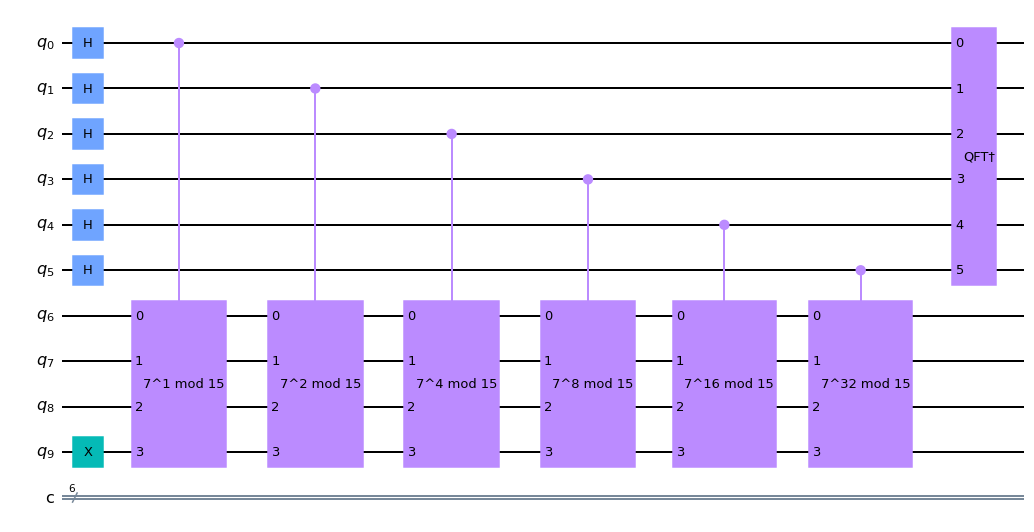

In [75]:
qc = amod15_circuit(6, a)
qc.draw(output='mpl')

In [84]:
def qpe_amod15(a):
    n_count = 4
    qc = amod15_circuit(n_count, a)
    
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    
    return phase

## find a guess of r

In [85]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r

Register Reading: 1100
Corresponding Phase: 0.750000


Fraction(3, 4)

In [86]:
frac = Fraction(phase).limit_denominator(N)
s, r = frac.numerator, frac.denominator
print(r)

4


In [87]:
guesses = [gcd(a ** (r // 2) - 1, N), gcd(a ** (r // 2) + 1, N)]
print(sorted(guesses))

[3, 5]


## repeats the algorithm until at least one factor of 15 is found

In [88]:
factor_found = False
attempt = 0

while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = sorted([gcd(a ** (r // 2) - 1, N), gcd(a ** (r // 2) + 1, N)])
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 0000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 2:
Register Reading: 0100
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***
